# Class for predicting label given model and image

In [26]:
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
import pandas as pd
import numpy as np
import torch

mpl.rcParams['text.color'], mpl.rcParams['axes.labelcolor'], mpl.rcParams['xtick.color'], mpl.rcParams['ytick.color'] = ['white']*4

class Predict:
    image_size = (100, 100)
    def __init__(self, model, normalize=True, class_mapping=None):
        '''
        model:torchvision.models - pytorch model with loaded weights
        normalize:model - if True, normalize with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] for respective RGB channels
        '''
        self.model = model
        if normalize:
            normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            self.transformer = transforms.Compose([transforms.Resize(self.image_size), transforms.ToTensor(), normalizer])
        else:
            self.transformer = transforms.Compose([transforms.Resize(self.image_size), transforms.ToTensor()])            
        self.normalize = normalize
        self.class_mapping = None if class_mapping is None else pd.DataFrame(class_mapping)

    def predict(self, source, source_type="infer", file_type="infer", batch_size=32, outFile=None, layout=None, figsize=None,
                show=False, misclassified=False, cachedir=None, return_prob=False, true_class=None, topk=0):
        '''
        source:str or iterable - if iterable, must be of homogenous type
                                 if str, can be directory containing only images, or a single image or a csv file with file names
        source_type:str:["infer" | "url" | "file" | "multi"]
        file_type:str:["infer" | "url" | "csv" | "image" | "directory"]
        batch_size:int - Batch size to process if multiple files passed
        outFile:str or None - if string, Predictions filename with path to save
        show:bool - 
        cachedir:str or None - 
        '''
        # Check is the source is a string or an iterable of Strings
        if isinstance(source, str):
            check = source.lower()
        elif hasattr(source, "__iter__"):
            check = source[0].lower()
            if source_type == "infer" or source_type == "url":
                source_type = "multi"
                if file_type == "infer" or file_type == "url":
                    if "http" in check:
                        source = tuple(map(lambda x: self.get_image(x, cachedir), source))
                    file_type = "image"
            else:
                print("source_type must be 'multi' or 'infer' when source is an Iterable of Strings")
                raise TypeError
        else:
            print("source should be either a String or an Iterable of Strings")
            raise TypeError
        # Resolve source_type
        if source_type == "infer" or source_type == "url":
            if "http" in check:
                source = self.get_image(source, cachedir)
                file_type = "image"
            source_type = "file"
        assert source_type in ["file", "multi"], "Unknown source_type"
        # Resolve file_type
        if file_type == "infer":
            if ".csv" in check:
                file_type = "csv"
            elif ".jpg" in check or ".jpeg" in check or ".png" in check:
                file_type = "image"
            else:    # Assume it is directory
                file_type = "directory"
        assert file_type in ["csv", "image", "directory"], "Unknown file_type"
        
        if file_type == "directory":
            from glob import glob
            if source_type == "multi":
                files = []
                for x in source:
                    files.extend(glob(f"{x}/*"))
                source = files
            else:
                source = glob(f"{source}/*")
        # Get files if source_type is an URL
        dataloader = self.build_loader(source, source_type, file_type, batch_size=batch_size, cachedir=cachedir)

        predictions = torch.empty(0, dtype=int)
        probabilities = torch.empty(0)        
        self.model.eval()
        for inputs in dataloader:
            with torch.set_grad_enabled(False):
                outputs = self.model.forward(inputs)
                _, preds = torch.max(outputs, 1)
                predictions = torch.cat((predictions, preds))
                probabilities = torch.cat([probabilities, outputs])
        df = pd.DataFrame({"predicted_class": predictions})
        df["path"] = source
        if self.class_mapping is not None:
            df["predicted_name"] = df.predicted_class.apply(lambda x: self.class_mapping.loc[x])
        if true_class is not None:
            if isinstance(true_class, str):
                df["true_name"] = true_class
                df["true_class"] = df.true_name.apply(lambda x: self.class_mapping.index[self.class_mapping.iloc[:, 0] == x][0])
            elif isinstance(true_class, int):
                df["true_class"] = true_class
                df["true_name"] = df.true_class.apply(lambda x: self.class_mapping.loc[x])
            else:
                if isinstance(true_class[0], str):
                    df["true_name"] = true_class
                    df["true_class"] = df.true_name.apply(lambda x: self.class_mapping.index[self.class_mapping.iloc[:, 0] == x][0])
                elif isinstance(true_class[0], int):
                    df["true_class"] = true_class
                    df["true_name"] = df.true_class.apply(lambda x: self.class_mapping.loc[x])
        if outFile:
            df.to_csv(outFile, header=True, index=False)
            print(f"Written to '{outFile}'")
        if show:
            self.show(df, misclassified=misclassified, layout=layout, figsize=figsize)
        self.pred_df = df
        if return_prob and topk > 0:
            
        elif return_prob:
            return torch.nn.Softmax(dim=1)(probabilities)

    def build_loader(self, path, source_type, file_type, batch_size=32, cachedir=None):
        if source_type == "multi":
            if file_type == "image":
                return self.datagen(path, batch_size)
            elif file_type == "directory":    # Multiple directories
                # Yet to check
                return self.datagen(path, batch_size)
            elif file_type == "csv":
                raise NotImplementedError
        elif source_type == "file":
            if file_type == "image":
                # model expects 4 dimensions, hence unsqueeze to add dummy dimension
                #return [transform_single(Image.open(path))]
                return [self.transformer(Image.open(path).convert('RGB')).unsqueeze(0)]
            elif file_type == "csv":
                raise NotImplementedError
            elif file_type == "directory":
                return self.datagen(path, batch_size)
            else:
                raise ValueError

    def datagen(self, files, batch_size):
        for i in range(0, len(files), batch_size):
            # Index exceeded is surprisingly handled automatically
            yield torch.stack(tuple(map(lambda f: self.transformer(Image.open(f).convert('RGB')), files[i:i+batch_size])))

    @staticmethod
    def transform_single(img, input_size=100):
        # Repeat mean and std to match image size
        # Check if means matches their respective channels
        m = np.repeat(np.repeat(np.array([0.485, 0.456, 0.406]).reshape(-1, 1), input_size, axis=1).reshape(3, input_size, 1), input_size, axis=2)
        s = np.repeat(np.repeat(np.array([0.229, 0.224, 0.225]).reshape(-1, 1), input_size, axis=1).reshape(3, input_size, 1), input_size, axis=2)
        # np.transpose since model expects (channel, height, width)
        return torch.from_numpy(((np.transpose(img.resize((input_size, input_size)), (2, 0, 1)) - m) / s) \
                                .reshape(1, 3, input_size, input_size))

    @staticmethod
    def get_image(url, cachedir):
        '''
        if cachedir is not None, returns path to cached file
        else returns BytesIO buffer
        '''
        import requests
        res = requests.get(url)
        res.raise_for_status()
        if cachedir:
            # Save to local
            local_file = f"{cachedir}/{url.rsplit('/', 1)[-1]}"
            with open(local_file, 'wb') as fw:
                fw.write(res.content)
            print(f"Cached file to {local_file}")
            return local_file
        from io import BytesIO
        return BytesIO(res.content)

    @staticmethod
    def show(df, misclassified=False, layout=None, figsize=None):
        if df is None:
            df = self.pred_df
        if misclassified:
            assert 'true_class' in df.columns, "True Classes not specified, can't determine misclassified"
            df = df[df.predicted_class != df.true_class]
        total = len(df)
        if total <= 0:
            print("No misclassification")
            return
        # Build image display subplots layout
        if layout:
            rows, cols = layout
            if total > rows*cols:
                warnings.warn("""Number of images (total=%d) is greater than total number of elements (%d) in layout (%d, %d).
                Will show only first (%d) images""" % (total, rows*cols, rows, cols, rows*cols))
                total = rows*cols
        else:
            # Default layout with 10 images per row
            cols = 10
            rows = total//cols+(1 if total%cols else 0)
        if figsize is None:
            figsize=(2*cols*rows, 5*rows)
        # Create image subplots
        fig, ax = plt.subplots(rows, cols, figsize=figsize)
        # Problem of shape being (n,)
        if rows==1:
            ax = ax.reshape((1, ax.shape[0]))
        for i in range(total):
            ax[i//cols, i%cols].imshow(Image.open(df['path'].iloc[i]))
            if 'true_class' in df.columns:
                ax[i//cols, i%cols].set_xlabel(f"Label:{df['true_class'].iloc[i]}:{df['true_name'].iloc[i]}")
            ax[i//cols, i%cols].set_title(f"Predicted:{df['predicted_class'].iloc[i]}:{df['predicted_name'].iloc[i]}")
            ax[i//cols, i%cols].set_xticks([])
            ax[i//cols, i%cols].set_yticks([])
        # Delete remaining axes if exist
        for j in range(i+1, rows*cols):
            fig.delaxes(ax[j//cols,j%cols])
        plt.show()

    def score(self, true_class=None):
        if true_class is None:
            assert 'true_class' in self.pred_df.columns, "No true_class specified, cannot compute score"
            true_class = self.pred_df['true_class']
        return (true_class == self.pred_df['predicted_class']).sum() / len(self.pred_df)

# Load model

In [23]:
from torchvision import models
num_classes = 131

model_path = "weights/mobilenet"
weights = torch.load(model_path)
model = models.mobilenet_v2(pretrained=False)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)
model.load_state_dict(weights)

<All keys matched successfully>

# Examples of using Predict

In [4]:
mapping = pd.read_csv("labels_mapping.csv", header=None, index_col=0)

## Single image from local

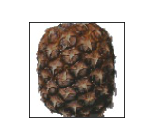

Accuracy 1.0


In [27]:
m = Predict(model, class_mapping=mapping)
prob = m.predict('images/Test/Pineapple/3_100.jpg', show=True, misclassified=False, return_prob=True, true_class="Pineapple")
print("Accuracy", m.score())

## Multiple images from local

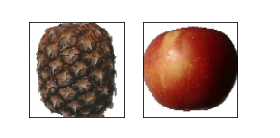

Accuracy 1.0


In [30]:
m = Predict(model, class_mapping=mapping)
prob = m.predict(['images/Test/Pineapple/3_100.jpg', 'images/Test/Apple Braeburn/3_100.jpg'], 
                        show=True, return_prob=True, true_class=["Pineapple", "Apple Braeburn"], figsize=(20, 40))
print("Accuracy", m.score())

## Images from directory

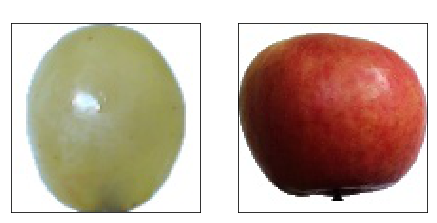

In [35]:
m = Predict(model, class_mapping=mapping)
prob = m.predict('images/check/', show=True, return_prob=True, figsize=(40, 20))

## Single image from URL with cache

Cached file to cache/fresh-pineapple-281kg-29-500x500.png


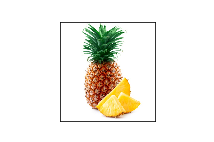

In [36]:
url = "https://5.imimg.com/data5/PW/ND/MY-46595757/fresh-pineapple-281kg-29-500x500.png"
um = Predict(model, class_mapping=mapping)
uprob = um.predict(url, return_prob=True, show=True, true_class="Pineapple", cachedir="cache")

## Single image from URL without cache

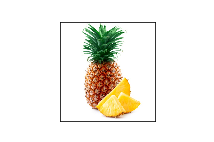

In [37]:
url = "https://5.imimg.com/data5/PW/ND/MY-46595757/fresh-pineapple-281kg-29-500x500.png"
um = Predict(model, class_mapping=mapping)
uprob = um.predict(url, return_prob=True, show=True, true_class="Pineapple")

## Multiple URLs

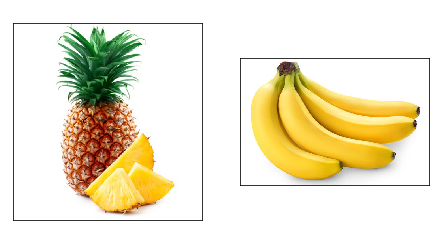

In [105]:
urls = ["https://5.imimg.com/data5/PW/ND/MY-46595757/fresh-pineapple-281kg-29-500x500.png", "https://cdn.mos.cms.futurecdn.net/42E9as7NaTaAi4A6JcuFwG-1200-80.jpg"]
um = Predict(model, class_mapping=mapping)
uprob = um.predict(urls, return_prob=True, show=True, true_class=["Pineapple", "Banana"], figsize=(40, 20))

In [114]:
np.array(pd.DataFrame(uprob[0]).sort_values(0, ascending=False).reset_index())[:5]

array([[1.17000000e+02, 8.32338572e-01],
       [3.60000000e+01, 8.37641954e-02],
       [9.80000000e+01, 2.27235835e-02],
       [2.40000000e+01, 1.71573311e-02],
       [1.70000000e+01, 1.32668503e-02]])

In [119]:
pd.DataFrame(np.asarray(uprob)).T.sort_values([0, 1], ascending=False)

,0,1
0,1.369559e-15,1.091392e-18
1,4.276187e-11,4.728671e-14
2,3.836040e-10,9.299329e-14
3,4.951146e-10,1.161112e-13
4,6.768176e-10,1.861531e-13
...,...,...
126,1.326685e-02,7.076674e-05
127,1.715733e-02,1.950364e-04
128,2.272358e-02,4.646778e-04
129,8.376420e-02,1.919188e-03


In [119]:
# Live webcam capture
import cv2
cap = cv2.VideoCapture(0)
cap.set(3, 640)    # Set Width
cap.set(4, 480)    # Set Height
labels_mapping = pd.read_csv("labels_mapping.csv", header=None, index_col=0)
try:
    while True:
        ret, frame = cap.read()
        #frame = torch.tensor(np.tile(frame, (1, 1, 1, 1)).transpose(0, 3, 1, 2))
        frame = transform(frame)
        with torch.set_grad_enabled(False):
            output = model.forward(frame)
            _, pred = torch.max(output, 1)

        print(labels_mapping.loc[int(pred), 1])
        k = cv2.waitKey(10) & 0xff # Press 'ESC' for exiting video
        if k == 27:
            break
except:
    cap.release()
    cv2.destroyAllWindows()

Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Peach Flat
Pear 2
Peach Flat
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
Pear 2
